https://sorabatake.jp/11731/

In [42]:
import numpy as np 
import os
import random 
#擬似乱数を生成するライブラリー 
from PIL import Image, ImageOps 
#画像処理ライブラリー
from sklearn.metrics import accuracy_score 
#モデルの正解率を計算するライブラリー
import glob 
#ファイルパス名を取得するライブラリ
import matplotlib.pyplot as plt 
#図をプロットするためのライブラリー

from mymodule import myfunc as mf
%matplotlib inline

PATH0 = "../snap/density/05/*"#コネクションなし
PATH1 = "../snap/density/07/*"#コネクションありに変える
PATH0TEST ="../snap/density/03/*"
PATH1TEST ="../snap/density/08/*"
ALTIMAGES0 = "../imgout/MLtest/0/*"
ALTIMAGES1 = "../imgout/MLtest/1/*"
def compress(array, LEVEL=10):
    return mf.convolute(array,mf.ave_carnel(LEVEL), stride = LEVEL)
temp = compress(mf.load(mf.gen_snap_path("density",1,1),z=3))
IMGSHAPE = temp.shape
print(IMGSHAPE)

np.random.seed(0) 
 #乱数のシードの設定

result   Y,X: 102 51
original Y,X: (1025, 513)
(102, 51)


# テストデータと訓練データを分ける
#### パスのリストを作って分ける場合
以下globで取得するとこをかきかえなければ

動作は軽いけど、ALTIMAGEと統合もしやすそう

#### フォルダにファイルコピーする場合
重いだけ？

# 水増し

In [33]:
#雲がない画像ファイルのパスのリストを取得
files = glob.glob(PATH0) 

#出力ディレクトリのパス
temp_output_dir = ALTIMAGES0

#ランダムな領域の切り取りを行う関数
def random_crop(imagearay, size=0.8):
    height, width, _ = imagearay.shape
    crop_size = int(min(height, width) * size)

    top = np.random.randint(0, height - crop_size)
    left = np.random.randint(0, width - crop_size)
    bottom = top + crop_size
    right = left + crop_size
    imagearay = imagearay[top:bottom, left:right,:]
    #motonosaizunimoosu
    return imagearay

def altarray_save(item):
    img = mf.load(item, z=3)
    file_name = os.path.basename(item)
    
    img_flip = np.flipud(img) # 画像の上下反転
    np.save(temp_output_dir + "flip_" + file_name , img_flip) # 画像保存
        
    img_mirror = np.fliplr(img) # 画像の左右反転
    np.save(temp_output_dir + "mirr_" + file_name , img_mirror) # 画像保存
            
    img_T = img.T # 画像の左右反転
    np.save(temp_output_dir + "trns_" + file_name , img_mirror) # 画像保存
    
    # img_crop = random_crop(img) # 画像の切り取り
    # img_crop = img_crop.resize((256, 256)) # 元のサイズに戻す
    # img_crop.save(temp_output_dir + file_name + "_crop.png") # 画像保存
 
for item in files:
    
    altarray_save(item)

In [34]:
#雲がある画像ファイルのパスのリストを取得
files = glob.glob(PATH1) 

#出力ディレクトリのパス
temp_output_dir = ALTIMAGES1

for item in files:
    altarray_save(item)


# 読み込み

In [73]:
# 訓練データ
num_of_data_clear = len(glob.glob(ALTIMAGES0)) # 雲がない画像の枚数
num_of_data_cloudy = len(glob.glob(ALTIMAGES1)) # 雲がある画像の枚数
num_of_data_total = num_of_data_clear + num_of_data_cloudy # 学習データの全枚数

N_col = IMGSHAPE[0]*IMGSHAPE[1]*1 # 行列の列数
X_train = np.zeros((num_of_data_total, N_col)) # 学習データ格納のためゼロ行列生成
y_train = np.zeros((num_of_data_total)) # 学習データに対するラベルを格納するためのゼロ行列生成

# 雲がない画像を行列に読み込む
path_list = glob.glob(ALTIMAGES0) 
i_count = 0

def load_regularize(item, type):
    if type == "b":
        im = mf.load(item, z=3)
    elif type == "np":
        im = np.load(item)
    else:
        raise "type argument required 'b' or 'np'"
    img_resize = compress(im)
    return ((img_resize - min(img_resize.flat)) / max(img_resize.flat)).flat # 正規化

for item in path_list:
    X_train[i_count,:] = load_regularize(item, type="np")
    y_train[i_count] = 0 # 雲がないことを表すラベル
    i_count += 1
  
# 雲がある画像を行列に読み込む
path_list = glob.glob(ALTIMAGES1) 

for item in path_list:
    X_train[i_count,:] = load_regularize(item, type="np")
    y_train[i_count] = 1 # 雲があることを表すラベル
    i_count += 1

result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X:

In [74]:
# テストデータ
num_of_data_clear = len(glob.glob(PATH0TEST)) # 雲がない画像の枚数
num_of_data_cloudy = len(glob.glob(PATH1TEST)) # 雲がある画像の枚数
num_of_data_total = num_of_data_clear + num_of_data_cloudy # テストデータの全枚数

N_col = IMGSHAPE[0]*IMGSHAPE[1]*1 # 行列の列数(RGBなら*3)
X_test = np.zeros((num_of_data_total, N_col)) # テストデータ格納のためゼロ行列生成
y_test = np.zeros(num_of_data_total) # テストデータに対するラベルを格納するためのゼロ行列生成

# 雲がない画像を行列に読み込む
path_list = glob.glob(PATH0TEST) 
i_count = 0
for item in path_list:

    X_test[i_count,:] = load_regularize(item, type="b")
    y_test[i_count] = 0 # 雲がないことを表すラベル
    i_count += 1

# 雲がある画像を行列に読み込む
path_list = glob.glob(PATH1TEST) 

for item in path_list:
    X_test[i_count,:] = load_regularize(item, type="b")
    y_test[i_count] = 1 # 雲があることを表すラベル
    i_count += 1 

result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X: 102 51
original Y,X: (1025, 513)
result   Y,X:

# 学習

# PCA

In [75]:
from sklearn.decomposition import PCA
N_dim =  100 # 49152(=128×128×3)の列を100列に落とし込む

pca = PCA(n_components=N_dim, random_state=0)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))

累積寄与率: 0.9999999999999996


# Linear SVC

In [76]:
from sklearn.svm import LinearSVC # ライブラリのインポート

model = LinearSVC(C=0.3, random_state=0) # インスタンスを生成

model.fit(X_train_pca, y_train) # モデルの学習

# 学習データに対する精度
print("Train :", model.score(X_train_pca,  y_train)) 

# テストデータに対する精度
print("Test :", model.score(X_test_pca, y_test)) 

Train : 1.0
Test : 1.0


c:\Users\lkxl1\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# KNeighbors Classifier

In [78]:
from sklearn.neighbors import KNeighborsClassifier # ライブラリのインポート

n_neighbors = int(np.sqrt(6000))  # kの設定

model = KNeighborsClassifier(n_neighbors = n_neighbors)  
model.fit(X_train_pca, y_train) # モデルの学習
    
# 精度
print("Train :", model.score(X_train_pca, y_train))
print("Test :", model.score(X_test_pca, y_test))

Train : 0.8333333333333334
Test : 0.5


# 非線形SVC RBFカーネル

In [80]:

from sklearn.svm import SVC # ライブラリのインポート

model = SVC(C=0.3, kernel='rbf', random_state=0) # インスタンスを生成 

model.fit(X_train_pca, y_train) # モデルの学習

# 精度
print("Train :", model.score(X_train_pca,  y_train))
print("Test :", model.score(X_test_pca, y_test))

Train : 1.0
Test : 0.5


# XGBoost

In [82]:
import xgboost as xgb # ライブラリのインポート

model = xgb.XGBClassifier(n_estimators=80, max_depth=4, gamma=3) # インスタンスの生成
           
model.fit(X_train_pca, y_train) # モデルの学習
   
# 精度
print("Train :", model.score(X_train_pca,  y_train))
print("Test :", model.score(X_test_pca, y_test))

[15:18:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train : 1.0
Test : 1.0


c:\Users\lkxl1\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


# まとめ

In [83]:
train_sizes = np.array([0.1, 0.33, 0.55, 0.78, 1. ]) # 用いる学習データの割合を全体の0.1〜1まで変化させる

train_sizes, train_scores_linearSVC, test_scores_linearSVC = learning_curve(
    model_linearSVC, X_train_pca, y_train, cv=5, train_sizes=train_sizes, random_state=0, shuffle=True
    ) # 様々学習データ数に対して、モデルを学習・評価する。

# 各学習データ数の場合について学習用データと検証用データに対する精度を求める。
train_scores_mean_linearSVC = np.mean(train_scores_linearSVC, axis=1)
train_scores_std_linearSVC = np.std(train_scores_linearSVC, axis=1)
validation_scores_mean_linearSVC = np.mean(validation_scores_linearSVC, axis=1)
validation_scores_std_linearSVC = np.std(validation_scores_linearSVC, axis=1)

NameError: name 'learning_curve' is not defined

NameError: name 'train_scores_mean_linearSVC' is not defined

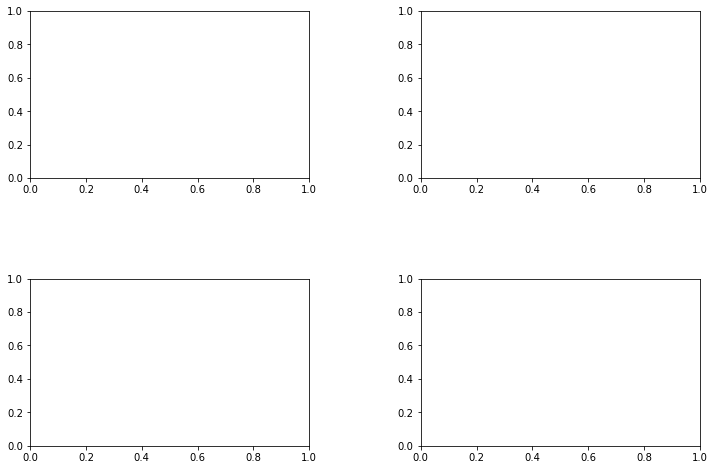

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Linear SVCの学習曲線
ax[0,0].plot(train_sizes, train_scores_mean_linearSVC, 'o-', color="r", label="Training score")
ax[0,0].plot(train_sizes, validation_scores_mean_linearSVC, 'o-', color="g", label="Test score")

ax[0, 0].set_title('Linear SVC')
ax[0, 0].set_xlabel('Number of Taining data')
ax[0, 0].set_ylabel('Accyracy')
ax[0,0].set_ylim(0.4, 0.8)
ax[0,0].legend(loc="best")

# kNNの学習曲線
ax[1,0].plot(train_sizes, train_scores_mean_kNN, 'o-', color="r", label="Training score")
ax[1,0].plot(train_sizes, validation_scores_mean_kNN, 'o-', color="g", label="Test score")

ax[1, 0].set_title('k-NN')
ax[1, 0].set_xlabel('Number of Taining data')
ax[1, 0].set_ylabel('Accuracy')
ax[1,0].set_ylim(0.5, 0.7)
ax[1,0].legend(loc="best")

# 非線形SVCの学習曲線
ax[0,1].plot(train_sizes, train_scores_mean_nonlinearSVC, 'o-', color="r", label="Training score")
ax[0,1].plot(train_sizes, validation_scores_mean_nonlinearSVC, 'o-', color="g", label="Test score")
ax[0, 1].set_title('non-linear SVC')
ax[0, 1].set_xlabel('Number of Taining data')
ax[0, 1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.7, 0.9)
ax[0,1].legend(loc="best")

# XGBoostの学習曲線
ax[1,1].plot(train_sizes, train_scores_mean_xgb, 'o-', color="r", label="Training score")
ax[1,1].plot(train_sizes, validation_scores_mean_xgb, 'o-', color="g", label="Test score")

ax[1, 1].set_title('XGBoost')
ax[1, 1].set_xlabel('Number of Taining data')
ax[1, 1].set_ylabel('Accuracy')
ax[1,1].set_ylim(0.7, 1.0)
ax[1,1].legend(loc="best")

In [7]:
import matplotlib.pyplot as plt
from mymodule import myfunc as mf
vX = mf.load(mf.gen_snap_path("velocityX",1,1),z=3)

C:/Users/lkxl1/OneDrive/デスクトップ/research/bigendian_data/


In [15]:
img = Image.open("../snap/velocityX/01/velocityX.01.01")
img_rotate = img.rotate(90)

UnidentifiedImageError: cannot identify image file '../snap/velocityX/01/velocityX.01.01'

In [13]:
mf.gen_snap_path("velocityX",1,1)

'C:/Users/lkxl1/OneDrive/デスクトップ/research/snap/velocityX/01/velocityX.01.01'

In [17]:
img = Image.open("../imgout/1005/png/density.1.png")

In [19]:
img.type

AttributeError: 'PngImageFile' object has no attribute 'type'

In [43]:
glob.glob(ALTIMAGES0) 

['../imgout/MLtest/0\\flip_density.01.05.npy',
 '../imgout/MLtest/0\\flip_density.02.05.npy',
 '../imgout/MLtest/0\\flip_density.03.05.npy',
 '../imgout/MLtest/0\\flip_density.04.05.npy',
 '../imgout/MLtest/0\\flip_density.05.05.npy',
 '../imgout/MLtest/0\\flip_density.06.05.npy',
 '../imgout/MLtest/0\\flip_density.07.05.npy',
 '../imgout/MLtest/0\\flip_density.08.05.npy',
 '../imgout/MLtest/0\\flip_density.09.05.npy',
 '../imgout/MLtest/0\\flip_density.10.05.npy',
 '../imgout/MLtest/0\\flip_density.11.05.npy',
 '../imgout/MLtest/0\\flip_density.12.05.npy',
 '../imgout/MLtest/0\\flip_density.13.05.npy',
 '../imgout/MLtest/0\\flip_density.14.05.npy',
 '../imgout/MLtest/0\\flip_density.15.05.npy',
 '../imgout/MLtest/0\\flip_density.16.05.npy',
 '../imgout/MLtest/0\\flip_density.17.05.npy',
 '../imgout/MLtest/0\\flip_density.18.05.npy',
 '../imgout/MLtest/0\\flip_density.19.05.npy',
 '../imgout/MLtest/0\\flip_density.20.05.npy',
 '../imgout/MLtest/0\\mirr_density.01.05.npy',
 '../imgout/M

In [69]:
X_train[0]

array([0.6685802 , 0.66858032, 0.66858038, ..., 0.00578028, 0.00577998,
       0.00577924])

In [71]:
np.zeros((num_of_data_total, N_col)).shape

(40, 5202)

In [72]:
num_of_data_total

40